In [976]:
from KoopmanismResponse.dynamical_systems.Models import Arnold_map
from KoopmanismResponse.utils.data_processing import (
    get_spectral_properties,
    get_acf,
    Koopman_correlation_function,
    get_observables_response_ArnoldMap
)
from KoopmanismResponse.utils.paths import get_data_folder_path
from KoopmanismResponse.EDMD.EDMD import Edmd_Fourier, TSVD
import numpy as np
from matplotlib import pyplot as plt
import pickle
from typing import List, Optional

In [977]:
two_dim_map = Arnold_map()
two_dim_map.set_random_initial_condition()
two_dim_map.M = 10**5
t, X = two_dim_map.integrate()

100%|██████████| 100000/100000 [00:02<00:00, 49880.93it/s]


### EDMD and Truncated Singular Value Decomposition

In [978]:
# Setting EDMD
edmd = Edmd_Fourier()
edmd.max_wave_vector = 8
edmd.box_length = 1
edmd._set_indices()

# Perform algorithm and get spectral properties
K = edmd.perform_edmd(data=X)
nus, V, W = get_spectral_properties(K)

100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


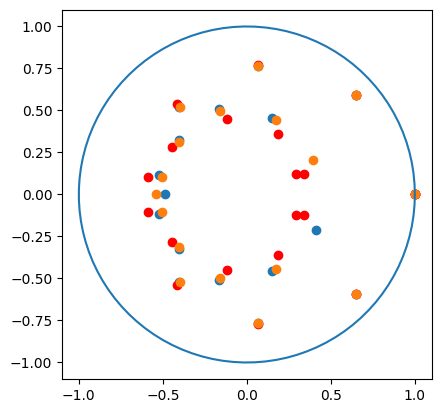

In [979]:
tsvd = TSVD(rel_threshold=10**-4)
_ = tsvd.decompose(edmd)
tsvd.get_spectral_properties()

fig, ax = plt.subplots()
thetas = np.linspace(0,2*np.pi,100)
ax.plot(np.cos(thetas),np.sin(thetas))
ax.set_aspect('equal')


nus_plot = nus[:17]
ax.scatter(np.real(nus_plot), np.imag(nus_plot))
mu = two_dim_map.mu_abs * np.exp(1j*( two_dim_map.alpha))
nus_det = (- mu)**(np.arange(10))
ax.scatter(np.real(nus_det),np.imag(nus_det),color='r')
ax.scatter(np.real(nus_det),-np.imag(nus_det),color='r')

nus_plot = tsvd.eigenvalues[:17]
ax.scatter(np.real(nus_plot), np.imag(nus_plot) )


### Correlation functions of Koopman Eigenfunctions

Text(0.5, 0, '$t$')

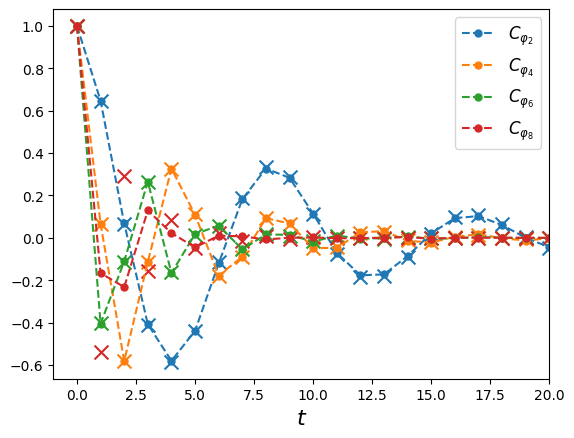

In [980]:
numbers = [1,3,5,7]
nlags = 30
max_time = min(X.shape[0],10**5)
Phi_traj = edmd.evaluate_koopman_eigenfunctions_batch(X[:max_time,:],V)
fig , ax = plt.subplots()

for i,number in enumerate(numbers):
    lags, cf = get_acf(Phi_traj[:,number], nlags = nlags,Dt=1)
    cf_th = np.real( tsvd.eigenvalues[number]**lags )
    ax.plot(lags,cf/cf[0],'--o',label= fr"$C_{{ \varphi_{number+1} }}$",markersize=5 )
    ax.scatter(lags,cf_th /cf_th[0],marker= 'x',s=100 )
    ax.set_xlim(-1,20)
    
ax.legend(fontsize=12)
ax.set_xlabel("$t$",size=16)   

### Correlation functions of general observables

In [981]:
# Correlation functions from trajectory
x , y = X[:max_time,0] , X[:max_time,1]
observables = [np.sin(2*np.pi*x)*np.sin(2*np.pi*y) , x**2 + y**2 , np.atan(x)*np.log(y + 0.1)]
cf_num = [get_acf(obs,nlags = nlags,Dt=1)[1] for obs in observables]

# Taking the projections w.r.t. Lebesgue of the functions
grid = np.linspace(0,1,200)
dx = grid[1] - grid[0]
dV = dx**2

Xg , Yg = np.meshgrid(grid,grid,indexing='ij')
grid_points = np.stack([Xg.ravel(), Yg.ravel()], axis=1)

observables = [
    np.sin(2 * np.pi * Xg) * np.sin(2 * np.pi * Yg),
    Xg**2 + Yg**2,
    np.atan(Xg) * np.log(Yg + 0.1)
]
observables_vals = [obs.ravel() for obs in observables]


Psi_Lebesgue = edmd.evaluate_dictionary_batch(grid_points)
projections =  [  Psi_Lebesgue.T.conj() @ (obs * dV) for obs in observables_vals] 

In [982]:
# Reconstruct in the correlation functions in the reduced space
reduced_projections = [ tsvd.project_reduced_space(projection) for projection in projections]

# Evaluate the Koopman projections and the reconstruction
Koop_projections = [tsvd.reduced_left_eigvecs.conj().T @ reduced_projection for reduced_projection in reduced_projections] #[W.conj().T @ proj for proj in projections] #[np.linalg.pinv(G_koop_n) @ Vn.conj().T @ edmd.G @ proj for proj in projections] #

# Scalar product of Koopman eigenfunctions
M = tsvd.reduced_right_eigvecs.conj().T @ tsvd.reduced_right_eigvecs


Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=M, eigenvalues=tsvd.eigenvalues, alpha1=koop_proj, alpha2=koop_proj
    ) for koop_proj in Koop_projections
]

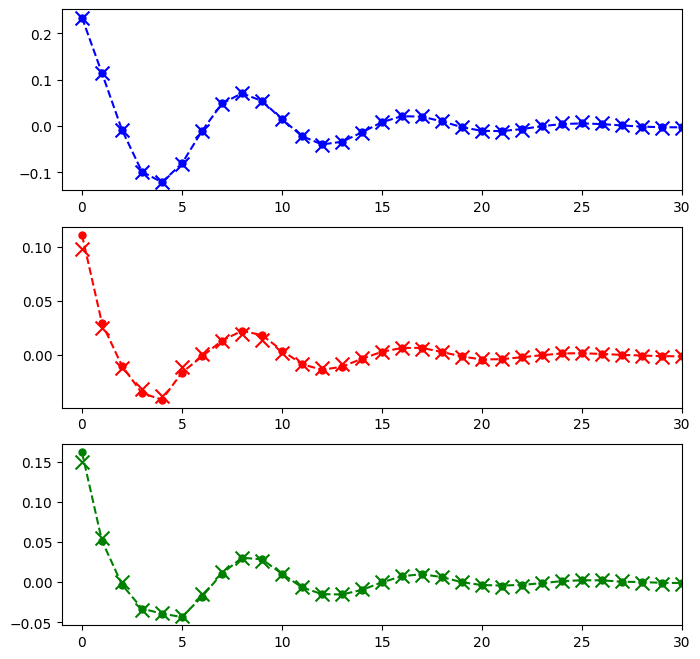

In [983]:
fig, ax = plt.subplots(nrows=3,figsize=(8,8))
labels = [f"$x$", f"$\sin^2(x)$" , f"$\ln(x+\delta)$"]
colors = ['b','r','g']
for index , (cf, Koop_rec,label)  in enumerate( zip( cf_num , Koop_reconstruction, labels) ):
    Koop_cf = np.real( np.asarray( [Koop_rec(lag) for lag in lags] ) )

    ax[index].plot(lags,cf,'--o',markersize=5,label=label,color=colors[index])
    ax[index].scatter(lags,Koop_cf ,s=100,marker="x",c=colors[index])

    ax[index].set_xlim(-1,30)
# ax.legend()

<!-- ### Response -->

### Response Theory

In [984]:
Gamma_data = Arnold_map()
Gamma_data.M = two_dim_map.M
Gamma_data.set_random_initial_condition()
t, X_Gamma = Gamma_data.integrate()

x_Gamma , y_Gamma = X_Gamma[:,0] , X_Gamma[:,1]

100%|██████████| 100000/100000 [00:01<00:00, 50466.26it/s]


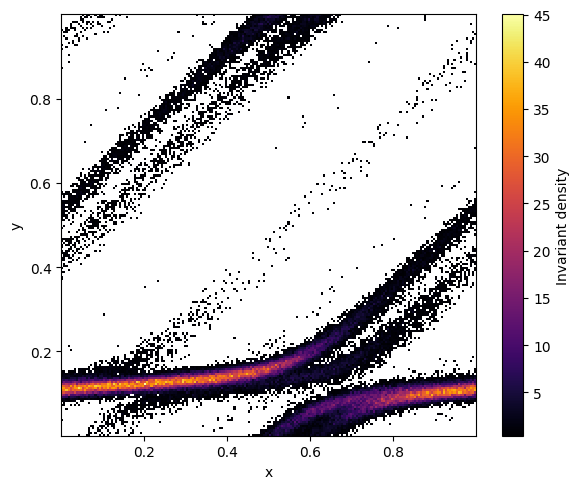

In [985]:
rho0 , edges = np.histogramdd(X_Gamma,bins=[200,200],density=True)

rho_plot = rho0.copy()
rho_plot[rho_plot < 10**(-4)] = np.nan
xedges , yedges = edges

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]
dV = dx*dy

# Coordinates for plotting (bin centers)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(xcenters, ycenters, indexing='ij')

# Plot
plt.figure(figsize=(6, 5))
plt.pcolormesh(Xc, Yc, rho_plot, cmap='inferno')
plt.colorbar(label='Invariant density')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

In [986]:
k_c = 8
factor = lambda k : 1#np.exp(-np.sum(k**2)/k_c**2)

### Sinusoidal Perturbation

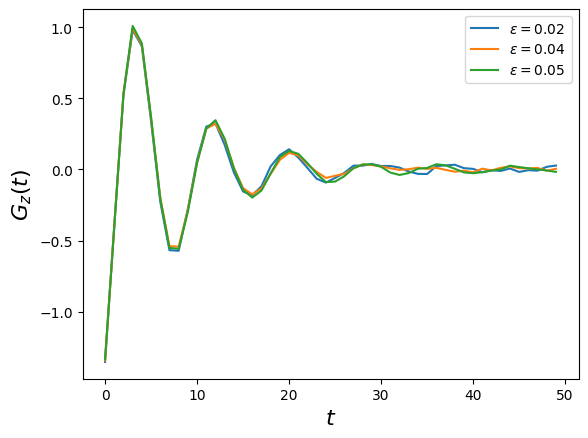

In [987]:
### Load data from the direct numerical experiments
data_folder_path = get_data_folder_path()
f_name = "response_two_dimensional_map_sinusoidal_perturbation.pkl"

with open(data_folder_path / f_name,"rb") as f:
    response_experiments_results = pickle.load(f)

RP = response_experiments_results["Positive Response"]
RM = response_experiments_results["Negative Response"]
amplitudes = response_experiments_results["Amplitudes"]
response_settings = response_experiments_results["Response Settings"]

t_resp = np.arange(1,response_settings.M+1)
Gs = np.zeros(RP[0].shape)
individual_responses = []
for rp , rm , amplitude in zip(RP,RM,amplitudes):
    response = (rp - rm) / (2*amplitude) 
    individual_responses.append(response)
    

fig, ax = plt.subplots()
for x, amplitude in zip(individual_responses,amplitudes):
    ax.plot(x[:,2],label=f"$\epsilon = ${amplitude}")
ax.legend()
ax.set_xlabel(f"$t$",size=16)
ax.set_ylabel(f"$G_{{z}}(t)$",size=16)

G = np.stack(individual_responses).mean(axis=0)
G_std = np.stack(individual_responses).std(axis=0)

#### Evaluating the response with $\gamma(x)$

In [988]:
# Finding projections of the observables
obs_grid = get_observables_response_ArnoldMap(grid_points)
projections =  [ ( Psi_Lebesgue.T.conj() @ obs * dV) for obs in obs_grid.T] 
# Evaluate the Koopman projections and the reconstruction
Koop_projections =  [W.conj().T @ proj for proj in projections] 


In [989]:
grid_rho0 = np.stack([Xc.ravel(), Yc.ravel()], axis=1)

perturbation_amplitude = np.sin(2*np.pi*(Xc - 2* Yc))
eta = - perturbation_amplitude * rho0
eta_vals = eta.ravel()
# Find projections of eta
Psi_Lebesgue = edmd.evaluate_dictionary_batch(grid_rho0)
G_Lebesgue = Psi_Lebesgue.T.conj() @ Psi_Lebesgue * dV
eta_dictionary_projections = Psi_Lebesgue.T.conj() @ eta_vals * dV
eta_rec = (Psi_Lebesgue @ eta_dictionary_projections).reshape(Xc.shape)
wave_vectors =  [np.asarray(x) for x in edmd.indices]

gamma_dictionary_projections = [1j*2*np.pi /edmd.box_length * np.sum(k) * eta_proj for k,eta_proj in zip(wave_vectors,eta_dictionary_projections)]
gamma_koopman_projections = W.T.conj() @ gamma_dictionary_projections

G_gamma = V.conj().T @  V

In [990]:
Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=G_gamma, eigenvalues=nus, alpha1=koop_proj, alpha2=gamma_koopman_projections
    ) for koop_proj in Koop_projections
]

G_reconstruction = np.stack( [np.real( np.asarray( [Koop_rec(t) for t in t_resp] ) ) for Koop_rec in Koop_reconstruction] ).T

Text(0.5, 0, '$t$')

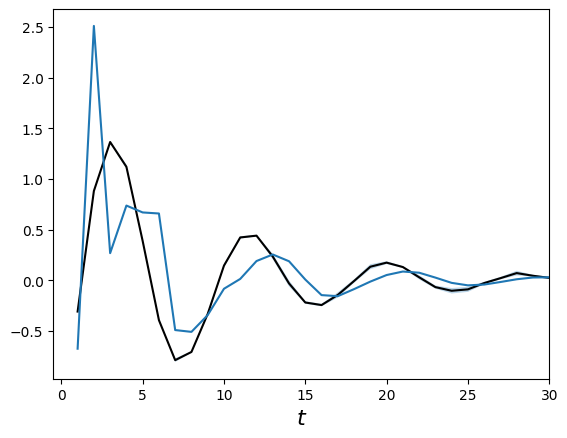

In [991]:
fig, ax = plt.subplots()
i = 0
ax.plot(t_resp,G[:,i],'-',color='k',label="Numerical Experiments")
# Add shaded std area around the mean
ax.fill_between(
    t_resp,
    G[:, i] - G_std[:, i],
    G[:, i] + G_std[:, i],
    alpha=0.3,
)
ax.plot(t_resp,G_reconstruction[:,i],label="Koopman Reconstruction")

ax.set_xlim(-0.5,30)
ax.set_xlabel(f"$t$",size=16)



### From timeseries

In [992]:
Psi_traj = edmd.evaluate_dictionary_batch(X_Gamma)
perturbation_field = np.sin(2*np.pi*(x_Gamma - 2*y_Gamma))
moms = ( perturbation_field[:,np.newaxis] * Psi_traj ).mean(axis=0)

Delta = [1j*2*np.pi /edmd.box_length*np.sum(k)*mom*factor(k) for mom, k in zip(moms,wave_vectors)]
# Gamma_dictionary_projections = np.linalg.pinv(edmd.G) @ Delta
# Gamma_Koopman_projections = W.conj().T @ Gamma_dictionary_projections


# # Reduced projection of observables
regularised_pseudo_inverse = tsvd.Ur @ np.diag(1/(tsvd.Sr )) @ tsvd.Ur.conj().T 
Gamma_dictionary_projections =  regularised_pseudo_inverse @ Delta
Gamma_dictionary_projections = tsvd.project_reduced_space(Gamma_dictionary_projections)
Gamma_Koopman_projections = tsvd.reduced_left_eigvecs.conj().T @ Gamma_dictionary_projections

reduced_projections = [tsvd.project_reduced_space(projection) for projection in projections]
reduced_Koop_projections = [tsvd.reduced_left_eigvecs.conj().T @ reduced_projection for reduced_projection in reduced_projections]


In [993]:
M = tsvd.reduced_right_eigvecs.conj().T @ tsvd.reduced_right_eigvecs
Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=M, eigenvalues=tsvd.eigenvalues, alpha1=koop_proj, alpha2=Gamma_Koopman_projections
    ) for koop_proj in reduced_Koop_projections
]


G_reconstruction = np.stack( [np.real( np.asarray( [Koop_rec(t) for t in t_resp] ) ) for Koop_rec in Koop_reconstruction] ).T

(-0.5, 30.0)

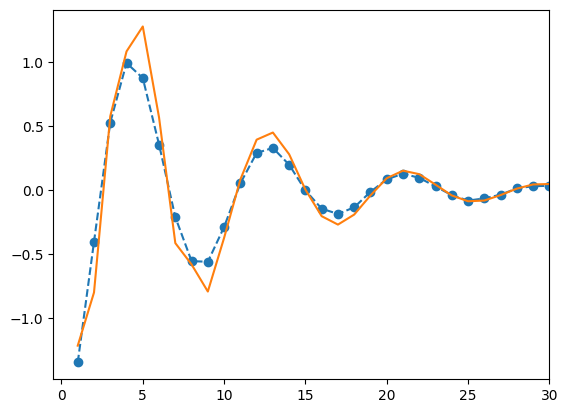

In [994]:
fig, ax = plt.subplots()
i = 2
ax.plot(t_resp,G[:,i],'--o')
ax.plot(t_resp,-G_reconstruction[:,i])
ax.set_xlim(-0.5,30)

### Multiple Experiments

In [995]:
# from tqdm import tqdm
# Ms = [5500,10**4,10**5,10**6]
# N_experiments = 1
# results = {}
# for integration_time in Ms:
#     experiments = []
#     for i in tqdm(range(N_experiments)):
#         # Let's do the experiment 
#         two_dim_map = Arnold_map()
#         two_dim_map.set_random_initial_condition()
#         two_dim_map.M = int(integration_time)
#         t, X_experiment = two_dim_map.integrate(show_progress=False)

#         # Setting EDMD
#         edmd = Edmd_Fourier()
#         edmd.max_wave_vector = 8
#         edmd.box_length = 1
#         edmd._set_indices()
#         _  = edmd.perform_edmd(data=X_experiment,show_progress=False)

        
#         tsvd = TSVD(rel_threshold=10**-4)
#         _ = tsvd.decompose(edmd)
#         tsvd.get_spectral_properties()

#         # Find projections of observables
#         grid = np.linspace(0,1,200)
#         dx = grid[1] - grid[0]
#         dV = dx**2

#         Xg , Yg = np.meshgrid(grid,grid,indexing='ij')
#         grid_points = np.stack([Xg.ravel(), Yg.ravel()], axis=1)
#         Psi_Lebesgue = edmd.evaluate_dictionary_batch(grid_points)
#         obs_grid = get_observables_response_ArnoldMap(grid_points)
#         projections =  [ ( Psi_Lebesgue.T.conj() @ obs * dV) for obs in obs_grid.T] 
        
#         # Evaluate Gamma on the same trajectory
#         x_Gamma_experiment , y_Gamma_experiment =  X_experiment[:,0] , X_experiment[:,1]
#         # Moments from the trajectory
#         Psi_traj = edmd.evaluate_dictionary_batch(X_experiment)
#         perturbation_field = np.sin(2*np.pi*(x_Gamma_experiment - 2*y_Gamma_experiment))
#         moms = ( perturbation_field[:,np.newaxis] * Psi_traj ).mean(axis=0)
       
#         Delta = [1j*2*np.pi /edmd.box_length*np.sum(k)*mom*factor(k) for mom, k in zip(moms,wave_vectors)]


#         # Reduced projection of observables
#         regularised_pseudo_inverse = tsvd.Ur @ np.diag(1/(tsvd.Sr)) @ tsvd.Ur.conj().T 
#         Gamma_dictionary_projections =  regularised_pseudo_inverse @ Delta
#         Gamma_dictionary_projections = tsvd.project_reduced_space(Gamma_dictionary_projections)
#         Gamma_Koopman_projections = tsvd.reduced_left_eigvecs.conj().T @ Gamma_dictionary_projections

#         reduced_projections = [tsvd.project_reduced_space(projection) for projection in projections]
#         reduced_Koop_projections = [tsvd.reduced_left_eigvecs.conj().T @ reduced_projection for reduced_projection in reduced_projections]

#         # Spectral reconstruction 
#         M = tsvd.reduced_right_eigvecs.conj().T @ tsvd.reduced_right_eigvecs
#         Koop_reconstruction = [
#             lambda t, koop_proj=koop_proj: Koopman_correlation_function(
#                 t=t, M=M, eigenvalues=tsvd.eigenvalues, alpha1=koop_proj, alpha2=Gamma_Koopman_projections
#             ) for koop_proj in reduced_Koop_projections
#         ]

#         G_reconstruction = np.stack( [np.real( np.asarray( [Koop_rec(t) for t in t_resp] ) ) for Koop_rec in Koop_reconstruction] ).T
#         experiments.append(G_reconstruction)

#     results[integration_time] = experiments
# results["Number_Experiments"] = N_experiments
# results["Length_trajectory"] = Ms

### Coefficient Perturbation

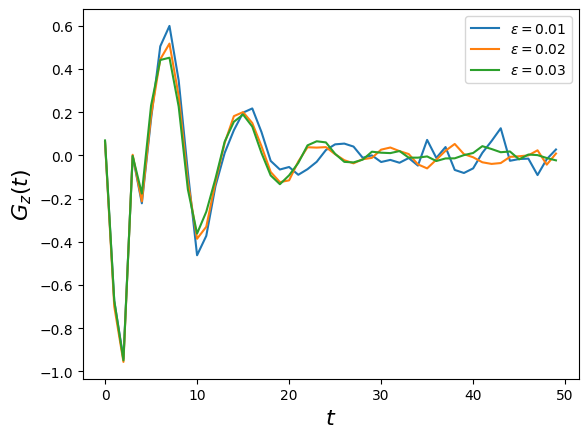

In [996]:
### Load data from the direct numerical experiments
data_folder_path = get_data_folder_path()
f_name = "response_two_dimensional_map_coefficient_perturbation.pkl"

with open(data_folder_path / f_name,"rb") as f:
    response_experiments_results = pickle.load(f)

RP = response_experiments_results["Positive Response"]
RM = response_experiments_results["Negative Response"]
amplitudes = response_experiments_results["Amplitudes"]
response_settings = response_experiments_results["Response Settings"]

t_resp = np.arange(1,response_settings.M+1)
G = np.zeros(RP[0].shape)
individual_responses = []
for rp , rm , amplitude in zip(RP,RM,amplitudes):
    response = (rp - rm) / (2*amplitude) 
    individual_responses.append(response)
    G +=  response
    
fig, ax = plt.subplots()
for x, amplitude in zip(individual_responses,amplitudes):
    ax.plot(x[:,1],label=f"$\epsilon = ${amplitude}")
ax.legend()
ax.set_xlabel(f"$t$",size=16)
ax.set_ylabel(f"$G_{{z}}(t)$",size=16)

G = np.stack(individual_responses).mean(axis=0)
G_std = np.stack(individual_responses).std(axis=0)

### Evaluating the response with \gamma(x)

In [997]:
perturbation_amplitude = Xc
eta = - perturbation_amplitude * rho0
eta_vals = eta.ravel()
# Find projections of eta
Psi_Lebesgue = edmd.evaluate_dictionary_batch(grid_rho0)
G_Lebesgue = Psi_Lebesgue.T.conj() @ Psi_Lebesgue * dV
eta_dictionary_projections = Psi_Lebesgue.T.conj() @ eta_vals * dV
eta_rec = (Psi_Lebesgue @ eta_dictionary_projections).reshape(Xc.shape)
wave_vectors =  [np.asarray(x) for x in edmd.indices]

gamma_dictionary_projections = [1j*2*np.pi /edmd.box_length * k[0] * eta_proj for k,eta_proj in zip(wave_vectors,eta_dictionary_projections)]
gamma_koopman_projections = W.T.conj() @ gamma_dictionary_projections

G_gamma = V.conj().T @  V

In [998]:
Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=G_gamma, eigenvalues=nus, alpha1=koop_proj, alpha2=gamma_koopman_projections
    ) for koop_proj in Koop_projections
]

G_reconstruction_gamma = np.stack( [np.real( np.asarray( [Koop_rec(t) for t in t_resp] ) ) for Koop_rec in Koop_reconstruction] ).T

Text(0.5, 0, '$t$')

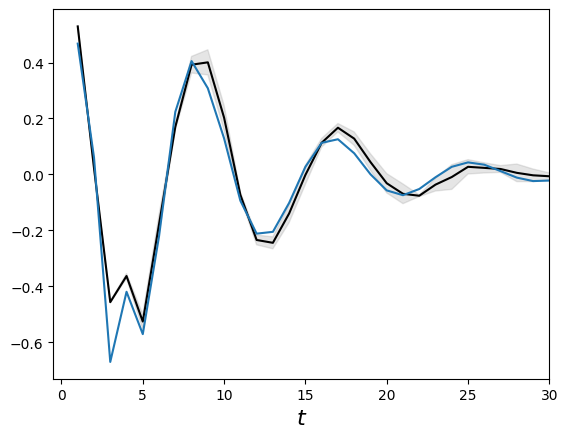

In [999]:
fig, ax = plt.subplots()
i = 3
ax.plot(t_resp,G[:,i],'-',color='k',label="Numerical Experiments")
# Add shaded std area around the mean
ax.fill_between(
    t_resp,
    G[:, i] - G_std[:, i],
    G[:, i] + G_std[:, i],
    alpha=0.2,color = 'grey'
)
ax.plot(t_resp,G_reconstruction_gamma[:,i],label="Koopman Reconstruction")
ax.set_xlim(-0.5,30)
ax.set_xlabel(f"$t$",size=16)



### From timeseries

In [1000]:
Psi_traj = edmd.evaluate_dictionary_batch(X_Gamma)
perturbation_field = x_Gamma
moms = ( perturbation_field[:,np.newaxis] * Psi_traj ).mean(axis=0)

Delta = [1j*2*np.pi /edmd.box_length*k[0]*mom*factor(k) for mom, k in zip(moms,wave_vectors)]

# # Reduced projection of observables
regularised_pseudo_inverse = tsvd.Ur @ np.diag(1/(tsvd.Sr )) @ tsvd.Ur.conj().T 
Gamma_dictionary_projections =  regularised_pseudo_inverse @ Delta
Gamma_dictionary_projections = tsvd.project_reduced_space(Gamma_dictionary_projections)
Gamma_Koopman_projections = tsvd.reduced_left_eigvecs.conj().T @ Gamma_dictionary_projections

reduced_projections = [tsvd.project_reduced_space(projection) for projection in projections]
reduced_Koop_projections = [tsvd.reduced_left_eigvecs.conj().T @ reduced_projection for reduced_projection in reduced_projections]


In [1001]:
M = tsvd.reduced_right_eigvecs.conj().T @ tsvd.reduced_right_eigvecs
Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=M, eigenvalues=tsvd.eigenvalues, alpha1=koop_proj, alpha2=Gamma_Koopman_projections
    ) for koop_proj in reduced_Koop_projections
]

G_reconstruction_time_series = np.stack( [np.real( np.asarray( [Koop_rec(t) for t in t_resp] ) ) for Koop_rec in Koop_reconstruction] ).T

(-0.5, 30.0)

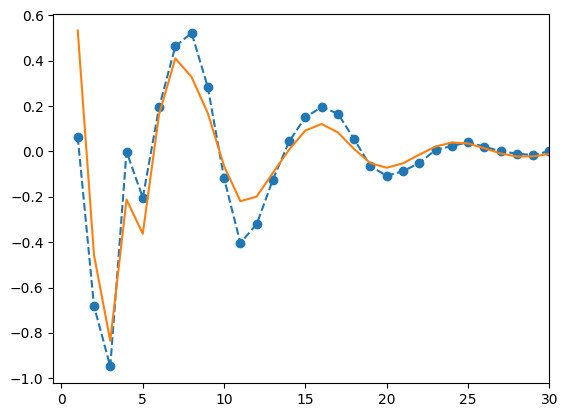

In [1002]:
fig, ax = plt.subplots()
i = 1
ax.plot(t_resp,G[:,i],'--o')
ax.plot(t_resp,G_reconstruction_time_series[:,i])
ax.set_xlim(-0.5,30)

In [1003]:
# from tqdm import tqdm
# Ms = [1500,10**4,10**5,10**6]
# N_experiments = 20
# results = {}
# for integration_time in Ms:
#     experiments = []
#     for i in tqdm(range(N_experiments)):
#         # Let's do the experiment 
#         two_dim_map = Arnold_map()
#         two_dim_map.set_random_initial_condition()
#         two_dim_map.M = int(integration_time)
#         t, X = two_dim_map.integrate(show_progress=False)

#         # Setting EDMD
#         edmd = Edmd_Fourier()
#         edmd.max_wave_vector = 8
#         edmd.box_length = 1
#         edmd._set_indices()
#         _  = edmd.perform_edmd(data=X,show_progress=False)

        
#         tsvd = TSVD(rel_threshold=10**-4)
#         _ = tsvd.decompose(edmd)
#         tsvd.get_spectral_properties()

#         # Find projections of observables
#         grid = np.linspace(0,1,200)
#         dx = grid[1] - grid[0]
#         dV = dx**2

#         Xg , Yg = np.meshgrid(grid,grid,indexing='ij')
#         grid_points = np.stack([Xg.ravel(), Yg.ravel()], axis=1)
#         Psi_Lebesgue = edmd.evaluate_dictionary_batch(grid_points)
#         obs_grid = get_observables_response_ArnoldMap(grid_points)
#         projections =  [ ( Psi_Lebesgue.T.conj() @ obs * dV) for obs in obs_grid.T] 
        
#         # Evaluate Gamma on the same trajectory
#         x_Gamma , y_Gamma =  X[:,0] , X[:,1]
#         # Moments from the trajectory
#         Psi_traj = edmd.evaluate_dictionary_batch(X)
#         perturbation_field = np.sin(2*np.pi*(x_Gamma - 2*y_Gamma))
#         moms = ( perturbation_field[:,np.newaxis] * Psi_traj ).mean(axis=0)
#         # Spectral Derivative
#         if integration_time < 2*10**4:
#             k_c = 6
#         else:
#             k_c = 8
            
#         factor = lambda k : np.exp(-np.sum(k**2)/k_c**2)
#         Delta = [1j*2*np.pi /edmd.box_length*np.sum(k)*mom*factor(k) for mom, k in zip(moms,wave_vectors)]


#         # Reduced projection of observables
#         regularised_pseudo_inverse = tsvd.Ur @ np.diag(1/(tsvd.Sr)) @ tsvd.Ur.conj().T 
#         Gamma_dictionary_projections =  regularised_pseudo_inverse @ Delta
#         Gamma_dictionary_projections = tsvd.project_reduced_space(Gamma_dictionary_projections)
#         Gamma_Koopman_projections = tsvd.reduced_left_eigvecs.conj().T @ Gamma_dictionary_projections

#         reduced_projections = [tsvd.project_reduced_space(projection) for projection in projections]
#         reduced_Koop_projections = [tsvd.reduced_left_eigvecs.conj().T @ reduced_projection for reduced_projection in reduced_projections]

#         # Spectral reconstruction 
#         M = tsvd.reduced_right_eigvecs.conj().T @ tsvd.reduced_right_eigvecs
#         Koop_reconstruction = [
#             lambda t, koop_proj=koop_proj: Koopman_correlation_function(
#                 t=t, M=M, eigenvalues=tsvd.eigenvalues, alpha1=koop_proj, alpha2=Gamma_Koopman_projections
#             ) for koop_proj in reduced_Koop_projections
#         ]

#         G_reconstruction = np.stack( [np.real( np.asarray( [Koop_rec(t) for t in t_resp] ) ) for Koop_rec in Koop_reconstruction] ).T
#         experiments.append(G_reconstruction)

#     results[integration_time] = experiments
# results["Number_Experiments"] = N_experiments
# results["Length_trajectory"] = Ms

In [1004]:
# data_path = get_data_folder_path()
# f_name = "multiple_spectral_decomposition_2d_sinusoidal.pkl"

# with open(data_path / f_name, "wb") as f:
#     pickle.dump(results, f)

In [1005]:
# fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(8,8))

# # Compute mean and std
# mean = np.mean(np.stack(results[Ms[-1]]), axis=0)
# std = np.std(np.stack(results[Ms[-1]]), axis=0)
# axes = ax.flat
# for i in range(4):

#     axes[i].plot(t_resp, G[:, i],'k')
#     axes[i].plot(t_resp, -mean[:, i])

#     # Add shaded std area around the mean
#     axes[i].fill_between(
#         t_resp,
#         -mean[:, i] - std[:, i],
#         -mean[:, i] + std[:, i],
#         alpha=0.3,
#     )



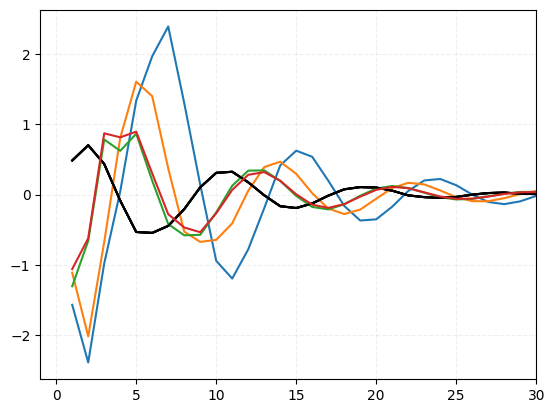

In [1006]:
fig, ax = plt.subplots()

observable_index = 2
labels = ["10^3","10^4","10^5","10^6"]
for M in results["Length_trajectory"]:
    # Compute mean and std
    mean = np.mean(np.stack(results[M]), axis=0)
    std = np.std(np.stack(results[M]), axis=0)

    ax.plot(t_resp, G[:, observable_index],'k')
    ax.plot(t_resp, -mean[:, observable_index])

    # Add shaded std area around the mean
    ax.fill_between(
        t_resp,
        -mean[:, observable_index] - std[:, observable_index],
        -mean[:, observable_index] + std[:, observable_index],
        alpha=0.1,
    )
    ax.set_xlim(-1,30)
    ax.grid(linestyle='--',alpha=0.2)

In [1007]:
# fig, ax = plt.subplots()

# observable_index = 2
# labels = ["10^3","10^4","10^5","10^6"]
# for M in results["Length_trajectory"]:
#     # Compute mean and std
#     mean = np.mean(np.stack(results[M]), axis=0)
#     std = np.std(np.stack(results[M]), axis=0)

#     ax.plot(t_resp, G[:, observable_index],'k')
#     ax.plot(t_resp, -mean[:, observable_index])

#     # Add shaded std area around the mean
#     ax.fill_between(
#         t_resp,
#         -mean[:, observable_index] - std[:, observable_index],
#         -mean[:, observable_index] + std[:, observable_index],
#         alpha=0.1,
#     )
#     ax.set_xlim(-1,30)
#     ax.grid(linestyle='--',alpha=0.2)